# Testing Custom Pipelines from HuggingFace

To standardise the feature extraction a potential suggestion is to define a custom pipeline from hugging face.

To define a custom pipeline one must instantiate an inherited class from pipeline and implement the following methods:

_santize_parameters: allows additional parameters to be passed to the pipeline either at initialisation or call time.
- Not sure we have any necessary parameters currently, so will implement this here as a placeholder (it's necessary to implement regardless)

preproccess: processes input for pipline class into format feedable to a model.
- This would be images from the dataset in our case, this seems to imply to me that our preprocessing steps should be held within this, however initially I'll implement it such that preprocess is a placeholder and just passes our already processed data into the model.

_forward: exactly how it sounds, feeds the input to the model. 
- This is wrapped in a few safeguards for the device in the parent class, but really should just be pass the data to the model.

postprocess: takes the otuput of _forward and formats it.
- In our case we just want to return the output from forward, we want the final features as a tensor (any necessary processing of the tensor is done by the metrics implementations).

In [1]:
from transformers import Pipeline

In [38]:
# First pass at a custom Pipeline:
from typing import Any, Dict, Optional, Union

import torch
from transformers.feature_extraction_utils import PreTrainedFeatureExtractor
from transformers.image_processing_utils import BaseImageProcessor
from transformers.modelcard import ModelCard

# from transformers.modeling_tf_utils import TFPreTrainedModel
from transformers.modeling_utils import PreTrainedModel
from transformers.pipelines.base import ArgumentHandler
from transformers.tokenization_utils import PreTrainedTokenizer

# from transformers.utils import ModelOutput, is_torch_available, is_vision_available, requires_backends


# if is_vision_available():
#     from PIL import Image

#     from transformers.image_utils import load_image


# if is_torch_available():
#     from transformers.models.auto.modeling_auto import MODEL_FOR_IMAGE_CLASSIFICATION_MAPPING


class features_pipeline(Pipeline):
    """Attempt to create a custom pipeline for inference returning only the features, not the classification."""

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # requires_backends(self, "vision")
        # self.check_model_type(
        #     MODEL_FOR_IMAGE_CLASSIFICATION_MAPPING
        # )

    def _sanitize_parameters(self, **pipeline_parameters):
        """Included as a palceholder, necessary to implement, not sure we need it."""
        preprocess_kwargs = {}
        if "maybe_arg" in pipeline_parameters:
            preprocess_kwargs["maybe_arg"] = pipeline_parameters["maybe_arg"]
        return preprocess_kwargs, {}, {}

    def preprocess(self, input, **preprocess_params):
        """Any necessary preprocessing required. Our preprocessing can be put in here, but will reimplement after testing basic version.

        Output should be a dictionary that can be passed to the model.
        """
        model_inputs = input
        # print(model_inputs)
        return model_inputs

    def _forward(self, model_inputs, **forward_parameters):
        # print(model_inputs)
        model_outputs = self.model(model_inputs)
        return model_outputs

    def postprocess(self, model_outputs, **postprocess_parameters) -> Any:
        """Simply returns model outputs. If we want to postprocess at all we can do that here though."""
        ouptput = model_outputs.logits
        return ouptput

    def __call__(self, inputs, **kwargs):
        """Turns this into callable object."""
        return super().__call__(inputs, **kwargs)

Now to test it with a model and some data.

In [6]:
from typing import Callable

import numpy as np

np.set_printoptions(edgeitems=30, linewidth=180)

from copy import copy

import requests
import torch
from datasets import Dataset, load_dataset
from numpy.typing import ArrayLike
from PIL import Image
from scipy.stats import spearmanr
from sklearn.base import BaseEstimator
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from transformers import AutoImageProcessor, AutoModelForImageClassification

Get a model with num_labels=0 for just features:

In [7]:
model_name = "google/vit-base-patch16-224"

model = AutoModelForImageClassification.from_pretrained(model_name, num_labels=0)
print(model)

loading configuration file config.json from cache at /Users/edable-heath/.cache/huggingface/hub/models--google--vit-base-patch16-224/snapshots/2ddc9d4e473d7ba52128f0df4723e478fa14fb80/config.json
Model config ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224",
  "architectures": [
    "ViTForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {},
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {},
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.31.0"
}

loading weights file pytorch_model.bin from cache at /Users/edable-heath/.cache/huggingface/hub/models--google--vit-base-patch16-224/snapshots/2ddc9d4e473d7ba52128f0df4723e478fa14fb80/pytorch_model.bin
Some weigh

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [8]:
processor = AutoImageProcessor.from_pretrained(model_name)
print(processor)

loading configuration file preprocessor_config.json from cache at /Users/edable-heath/.cache/huggingface/hub/models--google--vit-base-patch16-224/snapshots/2ddc9d4e473d7ba52128f0df4723e478fa14fb80/preprocessor_config.json
loading configuration file config.json from cache at /Users/edable-heath/.cache/huggingface/hub/models--google--vit-base-patch16-224/snapshots/2ddc9d4e473d7ba52128f0df4723e478fa14fb80/config.json
Model config ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224",
  "architectures": [
    "ViTForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "tench, Tinca tinca",
    "1": "goldfish, Carassius auratus",
    "2": "great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias",
    "3": "tiger shark, Galeocerdo cuvieri",
    "4": "hammerhead, hammerhead shark",
    "5": "electric ray, crampfish, numbfis

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}



Get some data (streamed here).

In [11]:
dataset = load_dataset("imagenet-1k", split="validation", token=True, streaming=True)

Using the latest cached version of the module from /Users/edable-heath/.cache/huggingface/modules/datasets_modules/datasets/imagenet-1k/a1e9bfc56c3a7350165007d1176b15e9128fcaf9ab972147840529aed3ae52bc (last modified on Tue Jul  4 12:42:56 2023) since it couldn't be found locally at imagenet-1k., or remotely on the Hugging Face Hub.


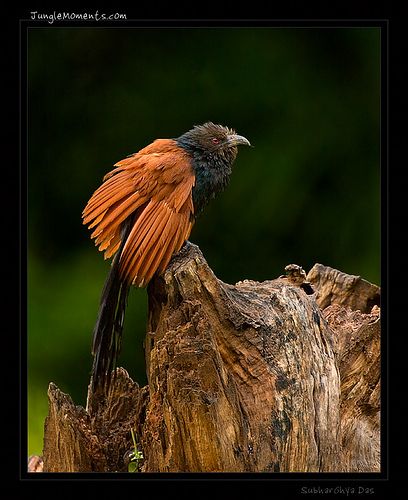

In [17]:
display(next(iter(dataset))["image"])

In [13]:
def iter_extr(iterable, idx_c=0):
    for idx, iter in enumerate(iterable):
        if idx == idx_c:
            return iter

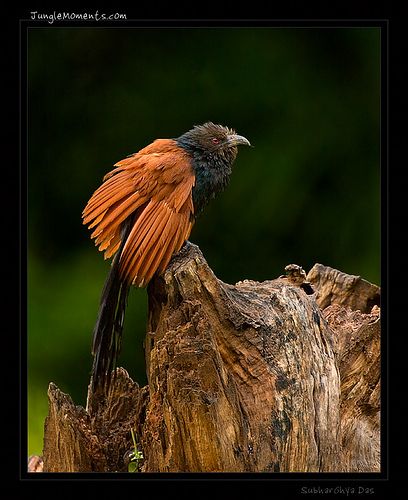

In [14]:
display(iter_extr(dataset, 0)["image"])

Preprocess the data (this can be implemented within the custom pipeline, but just testing it for now.)

In [16]:
def preprocess(examples):
    examples["pixel_values"] = [
        processor(image.convert("RGB"))["pixel_values"][0]
        for image in examples["image"]
    ]
    return examples


imgs = dataset.map(preprocess, remove_columns="image", batched=True, batch_size=1)
imgs = imgs.with_format("torch")

Test the pipeline

In [39]:
pipe = features_pipeline(model)

In [40]:
example_data = next(iter(imgs))["pixel_values"][None, :, :, :]

In [41]:
pipe(example_data)

tensor([[-2.0955e-01, -1.7934e-01,  6.8400e-01, -5.1751e-01, -1.3333e+00,
          3.8092e-01, -1.0818e+00,  1.8845e-01, -9.9801e-01, -1.0212e-02,
         -2.6711e-01,  1.0839e+00,  1.3619e+00, -5.7089e-02,  1.3110e-02,
          2.4124e-01,  1.6392e-01, -2.1566e-01,  5.0740e-01,  1.6421e+00,
         -5.8426e-01,  1.6186e+00,  1.2816e+00, -1.2749e+00, -4.3522e-01,
         -9.7474e-01,  6.4590e-01, -3.9170e-01, -3.9663e-01, -9.4166e-01,
         -2.2111e-02,  8.2703e-01, -1.9563e-02,  1.9177e-02, -3.3390e-01,
         -3.0926e-01,  3.0671e-01,  7.4761e-01, -2.2005e-01, -1.1672e+00,
         -1.4188e+00, -1.1374e+00, -1.0848e+00,  1.0464e-01,  9.4242e-01,
          3.2549e-01,  7.2269e-01, -1.5057e+00,  2.1468e-01, -1.0154e+00,
         -1.1898e-01,  6.3364e-01, -1.9425e-01, -3.0813e-01, -7.9147e-02,
          5.7870e-01,  3.5728e-01,  2.6440e-01,  8.9039e-01, -2.5191e-01,
          9.0011e-01, -1.4020e+00,  1.2225e-01, -3.7510e-01, -6.4882e-01,
          3.3562e-01, -9.6507e-01, -5.

## Try it with a different model

"microsoft/beit-large-patch16-512"

In [42]:
model_name = "microsoft/beit-large-patch16-512"

model = AutoModelForImageClassification.from_pretrained(model_name, num_labels=0)
print(model)

loading configuration file config.json from cache at /Users/edable-heath/.cache/huggingface/hub/models--microsoft--beit-large-patch16-512/snapshots/f03bc4a94ad012c74bdd32d80ec7169a751034f9/config.json
Model config BeitConfig {
  "_name_or_path": "microsoft/beit-large-patch16-512",
  "architectures": [
    "BeitForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "auxiliary_channels": 256,
  "auxiliary_concat_input": false,
  "auxiliary_loss_weight": 0.4,
  "auxiliary_num_convs": 1,
  "drop_path_rate": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "id2label": {},
  "image_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "label2id": {},
  "layer_norm_eps": 1e-12,
  "layer_scale_init_value": 0.1,
  "model_type": "beit",
  "num_attention_heads": 16,
  "num_channels": 3,
  "num_hidden_layers": 24,
  "out_indices": [
    3,
    5,
    7,
    11
  ],
  "patch_size": 16,
  "pool_scales": [
    1,
    2,
    3,
    6


BeitForImageClassification(
  (beit): BeitModel(
    (embeddings): BeitEmbeddings(
      (patch_embeddings): BeitPatchEmbeddings(
        (projection): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): BeitEncoder(
      (layer): ModuleList(
        (0): BeitLayer(
          (attention): BeitAttention(
            (attention): BeitSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=False)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (relative_position_bias): BeitRelativePositionBias()
            )
            (output): BeitSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
     

In [43]:
processor = AutoImageProcessor.from_pretrained(model_name)
print(processor)

loading configuration file preprocessor_config.json from cache at /Users/edable-heath/.cache/huggingface/hub/models--microsoft--beit-large-patch16-512/snapshots/f03bc4a94ad012c74bdd32d80ec7169a751034f9/preprocessor_config.json
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
size should be a dictionary on of the following set of keys: ({'width', 'height'}, {'shortest_edge'}, {'longest_edge', 'shortest_edge'}, {'longest_edge'}), got 512. Converted to {'height': 512, 'width': 512}.
crop_size should be a dictionary on of the following set of keys: ({'width', 'height'}, {'shortest_edge'}, {'longest_edge', 'shortest_edge'}, {'longest_edge'}), got 224. Converted to {'height': 224, 'width': 224}.
Image processor BeitImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": false,
  "do_normalize": true,
  "do_reduce_labels": false,
  "

BeitImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": false,
  "do_normalize": true,
  "do_reduce_labels": false,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "BeitImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 512,
    "width": 512
  }
}



reprocess data

In [44]:
def preprocess(examples):
    examples["pixel_values"] = [
        processor(image.convert("RGB"))["pixel_values"][0]
        for image in examples["image"]
    ]
    return examples


imgs = dataset.map(preprocess, remove_columns="image", batched=True, batch_size=1)
imgs = imgs.with_format("torch")

In [45]:
example_data = next(iter(imgs))["pixel_values"][None, :, :, :]

In [47]:
pipe = features_pipeline(model)

In [48]:
pipe(example_data)

tensor([[ 0.1337, -0.7469, -0.0723,  ...,  0.7512,  0.8535, -0.3324]])